## Libraries

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.layers import Lambda, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Activation, Concatenate
from tensorflow.keras.metrics import IoU, BinaryIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import cv2 as cv
import datetime
import matplotlib.pyplot as plt

## Loading Data

In [2]:
#home = os.environ['HOME']

In [3]:
#path_X = os.path.join(home,'raw_data/image_slices')
#path_y = os.path.join(home,'raw_data/mask_slices')

In [3]:
path_X = '/mnt/d/PDE/AerialImageDataset/slices_whole/train_image_slices'
path_y = '/mnt/d/PDE/AerialImageDataset/slices_whole/train_mask_slices'

In [4]:
split_ratio = 0.9

In [5]:
def train_val_split (path_X, path_y, split_ratio):
    X_names = os.listdir(path_X)
    y_names = os.listdir(path_y)
    y_path = [f'{path_y}/{file}' for file in y_names]
    X_path = [f'{path_X}/{file}' for file in X_names]
    train_X, val_X = X_path[:int(len(X_path)*split_ratio)], X_path[int(len(X_path)*split_ratio):]
    train_y, val_y = y_path[:int(len(y_path)*split_ratio)], y_path[int(len(y_path)*split_ratio):]
    return train_X, val_X, train_y, val_y 

In [6]:
train_X, val_X, train_y, val_y = train_val_split (path_X, path_y, split_ratio)

In [8]:
def verify_matching_input_labels(X_names, y_names):
    for x, y in zip(X_names, y_names):
        if os.path.basename(x) != os.path.basename(y):
            raise ValueError(f"X and Y not matching: {x, y}")

In [9]:
verify_matching_input_labels(train_X, train_y)

In [10]:
verify_matching_input_labels(val_X, val_y)

In [11]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)
    image = tf.image.decode_png(image, channels = 3)
    mask = tf.image.decode_png(mask, channels = 1) / 255 
    return image, mask

In [12]:
def batch_data (X_path, y_path, batch_size):
    ds_train = tf.data.Dataset.from_tensor_slices((X_path, y_path))
    return ds_train.shuffle(buffer_size = len(X_path), seed = 10).map(process_path).batch(batch_size)

In [13]:
def vis_cnn_feature_maps(model, image):
    """input model and image, this function will display images after go through each CNN layer"""
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers]
    feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    image = tf.expand_dims(image, axis=0)
    feature_maps = feature_map_model.predict(image)
    for layer_name, feature_map in zip(layer_names, feature_maps):
        if len(feature_map.shape) == 4: # Number of feature images/dimensions in a feature map of a layer 
            k = feature_map.shape[-1]  
            size=feature_map.shape[2]
            row = feature_map.shape[1]

            image_belt = np.array([[0]*k*size for i in range(row)])
            for i in range(k):
                feature_image = feature_map[0, :, :, i]  #first image of the batch for channel i
                feature_image -= feature_image.mean()
                feature_image /= feature_image.std()
                feature_image *=  64
                feature_image += 128
                feature_image = np.clip(feature_image, 0, 255)
                image_belt[:,i * size : (i + 1) * size] = feature_image

            scale = 20. / k
            plt.figure( figsize=(scale * k, scale) )
            plt.title ( layer_name )
            plt.grid  (False )
            plt.imshow(image_belt, aspect='auto')

### Training Dataset

In [15]:
train_dataset = batch_data(train_X, train_y, batch_size=8)

### Validation Dataset

In [16]:
val_dataset = batch_data(val_X, val_y, batch_size=8)

### Test Dataset

In [14]:
# path_X_TEST = os.path.join(home,'raw_data/TEST_slices/test_image_slices')
# path_y_TEST = os.path.join(home,'raw_data/TEST_slices/test_mask_slices')

In [15]:
def batch_data_test (path_X, path_y, batch_size):
    X_names = os.listdir(path_X)
    X_path = [f'{path_X}/{file}' for file in X_names]
    y_names = os.listdir(path_y)
    y_path = [f'{path_y}/{file}' for file in y_names]
    ds_train = tf.data.Dataset.from_tensor_slices((X_path, y_path))
    return ds_train.map(process_path).batch(batch_size)

In [16]:
#TEST_dataset = batch_data_test(path_X_TEST, path_y_TEST, batch_size=16)

## Model Definition

In [18]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [19]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters) #can be used as skip connection 
    p = MaxPooling2D((2,2))(x)
    return x, p

In [20]:
def decoder_block(inputs, skip_features, num_filters): #skip features are going to be the x returned from the encoder block
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [21]:
def dice_loss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

In [22]:
def loss_sum(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    o = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

In [44]:
def build_unet(img_height, img_width, channels):
    
    inputs = Input((img_height, img_width, channels))
    nomorlisation = Lambda(lambda x: x / 255)(inputs) #Normalize the pixels by dividing by 255

    #Encoder - downscaling (creating features/filter)
    skip1, pool1 = encoder_block(nomorlisation, 16)
    skip2, pool2 = encoder_block(pool1, 32) 
    skip3, pool3 = encoder_block(pool2, 64)
    skip4, pool4 = encoder_block(pool3, 128) 
    
    #Bottleneck or bridge between encoder and decoder
    b1 = conv_block(pool4, 256)
    
    #Decoder - upscaling (reconstructing the image and giving it precise spatial location)
    decoder1 = decoder_block(b1, skip4, 128)
    decoder2 = decoder_block(decoder1, skip3, 64)
    decoder3 = decoder_block(decoder2, skip2, 32)
    decoder4 = decoder_block(decoder3, skip1, 16)
    
    #Output
    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(decoder4)
    model = Model(inputs, outputs)
    
    iou = BinaryIoU()
    
    model.compile(optimizer='adam', loss=loss_sum, metrics=['accuracy', iou])
    
    #model.summary()
    
    return model


In [45]:
model = build_unet(256, 256, 3)

In [28]:
logs_dir = log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_dir , histogram_freq=1)
checkpoint_filepath = '../tmp/simple_unet/loss_sum_trainingset'
es = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', restore_best_weights=True)

In [49]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 500, callbacks=[es, checkpoint, tb_callback], verbose=1)

Epoch 1/500
 573/6295 [=>............................] - ETA: 17:32 - loss: 0.8428 - accuracy: 0.8705 - binary_io_u_1: 0.6260

KeyboardInterrupt: 

In [40]:
image = plt.imread(train_X[1])
mask = plt.imread(train_y[1])

In [47]:
model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>

1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_9996/2298169164.py:18: RuntimeWarning: invalid value encountered in divide
  feature_image /= feature_image.std()
/tmp/ipykernel_9996/2298169164.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure( figsize=(scale * k, scale) )


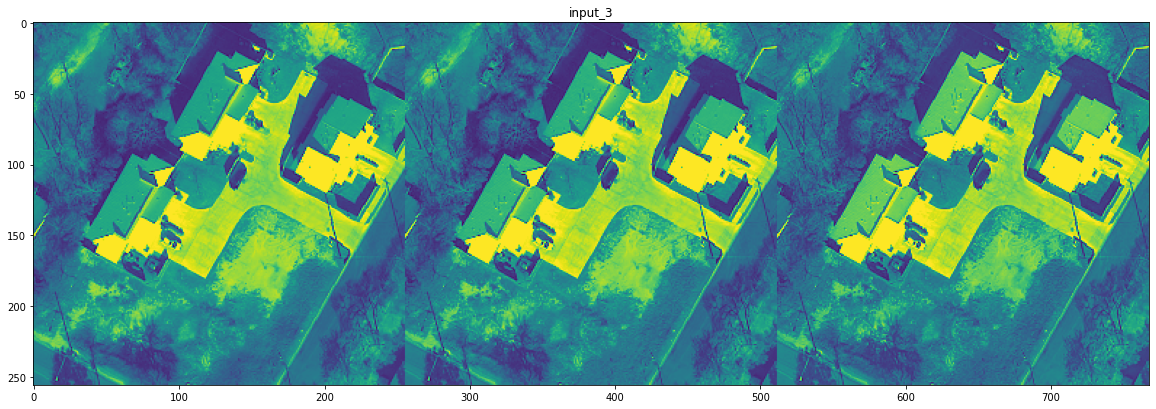

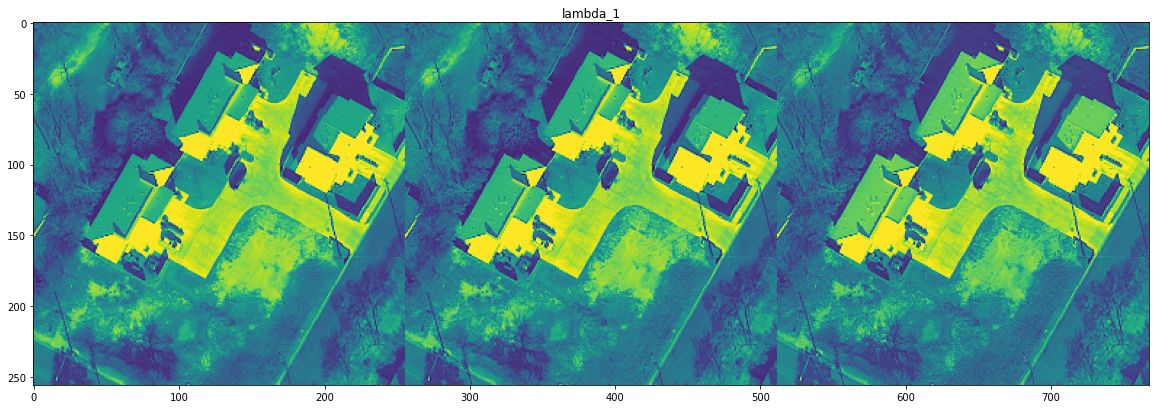

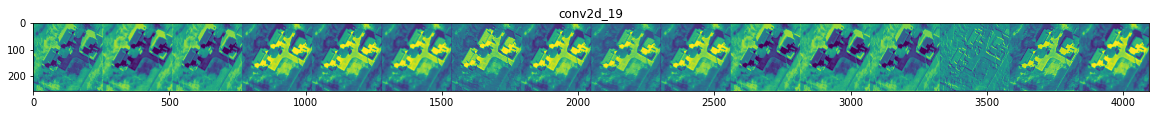

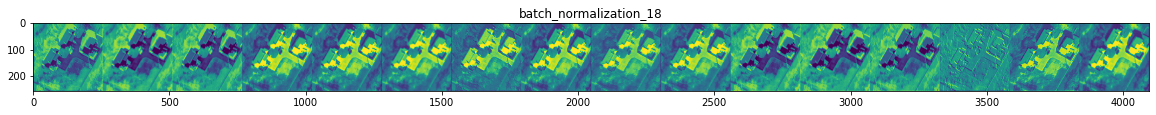

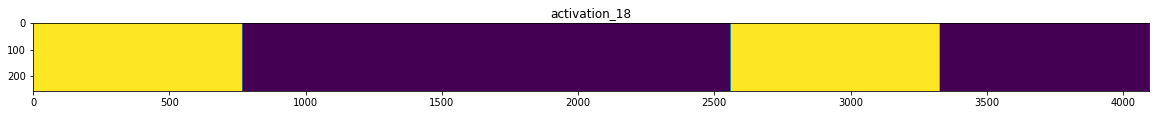

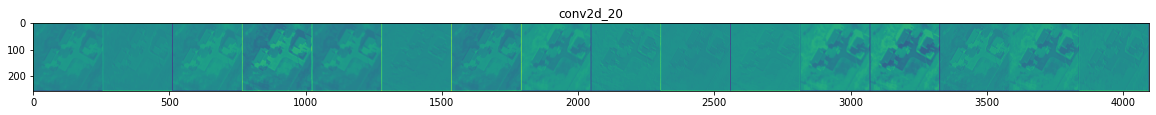

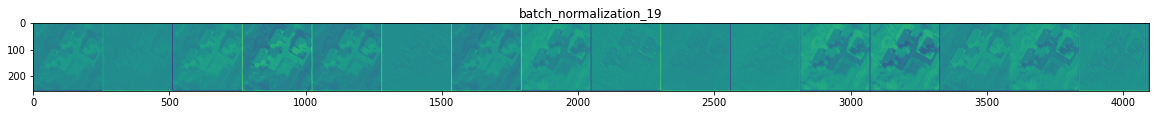

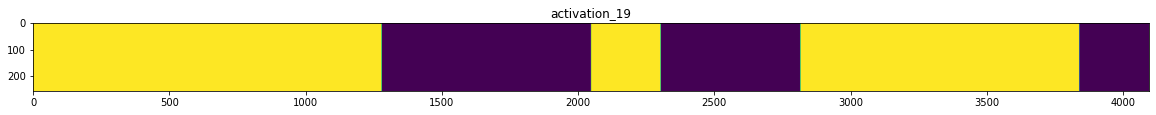

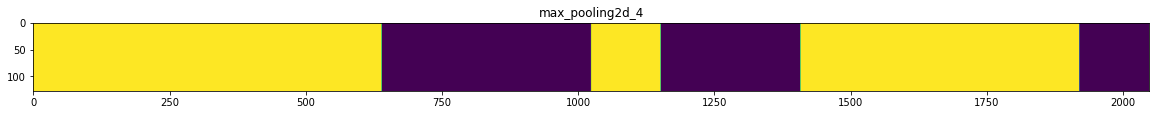

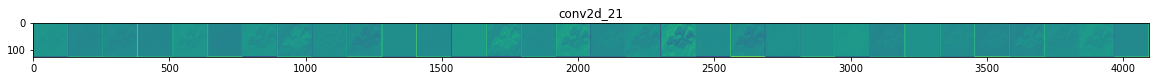

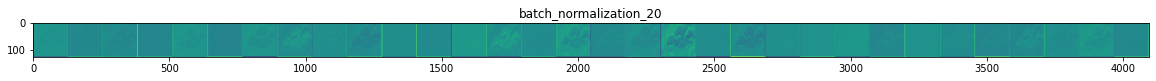

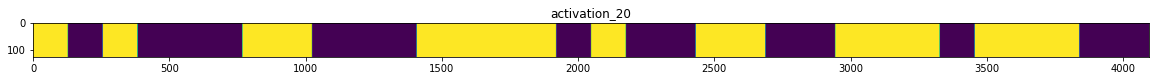

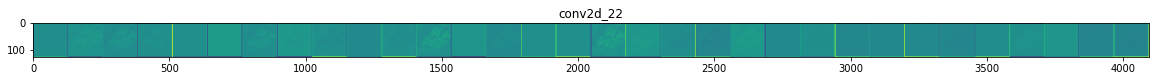

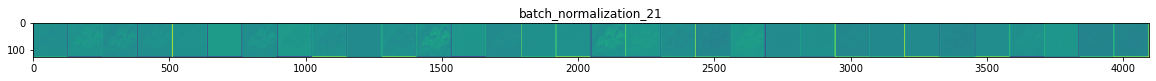

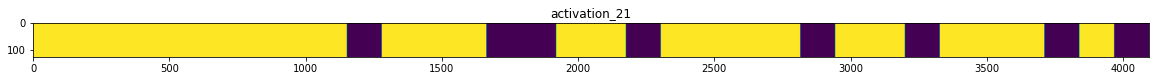

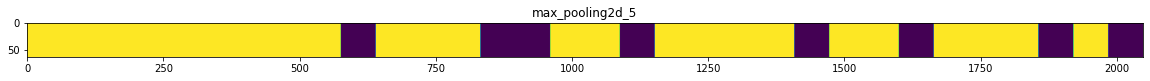

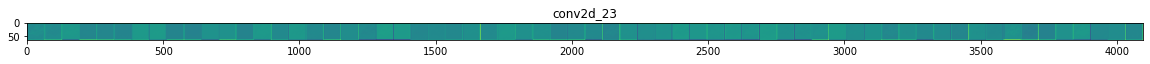

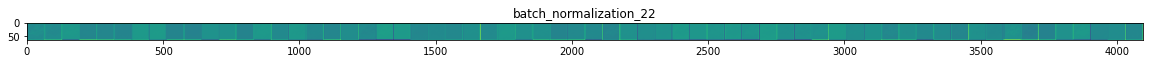

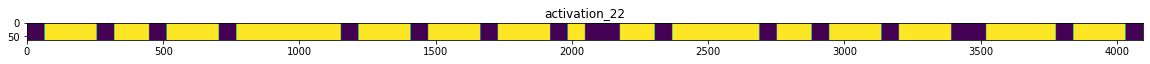

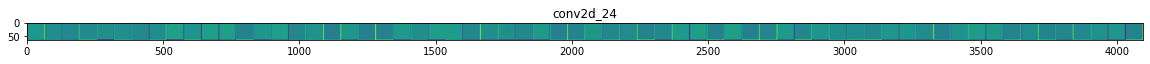

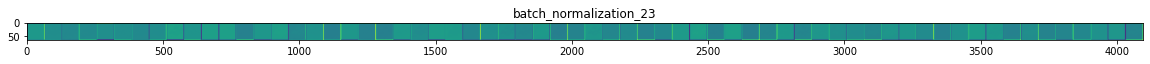

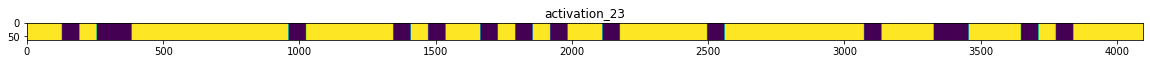

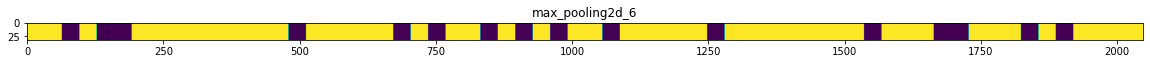

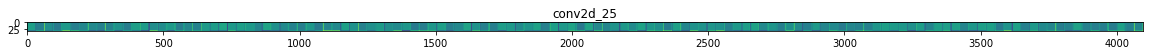

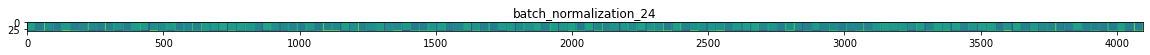

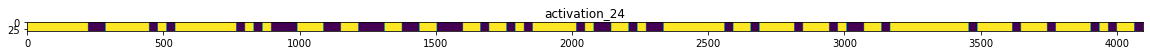

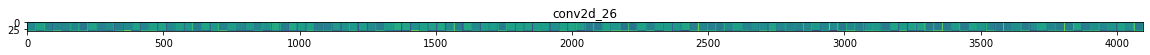

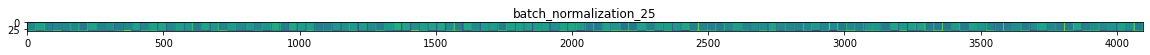

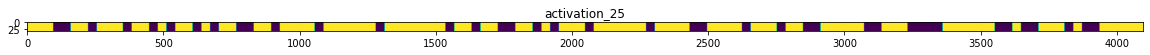

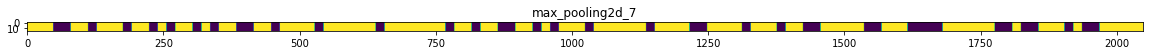

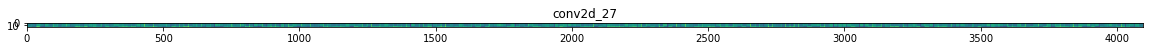

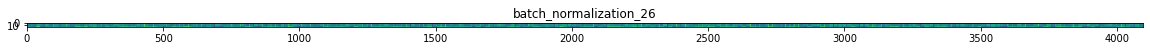

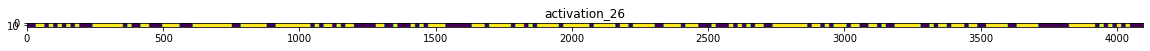

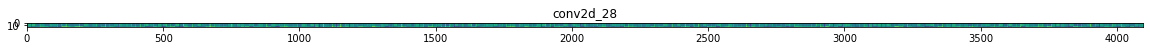

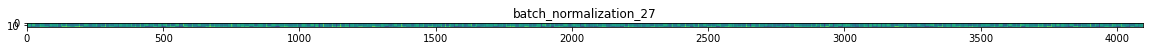

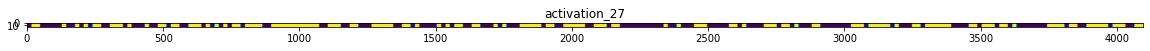

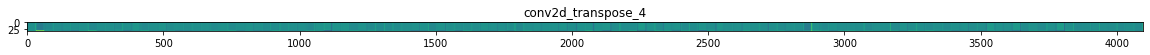

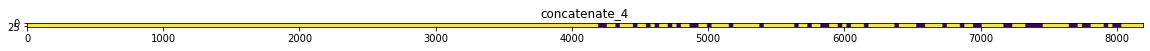

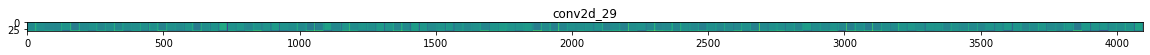

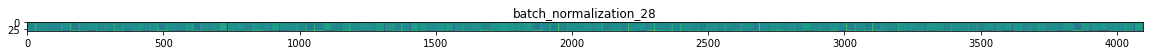

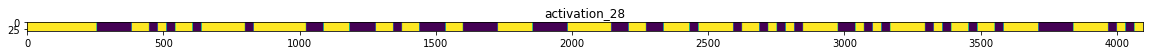

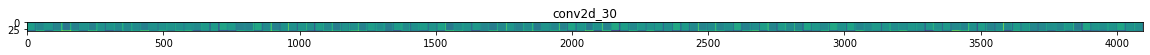

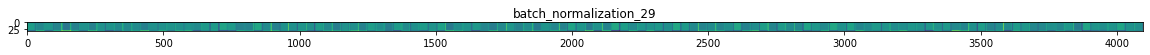

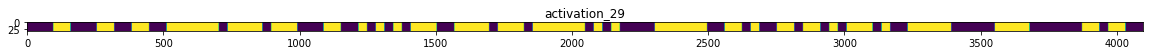

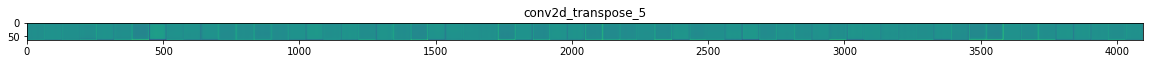

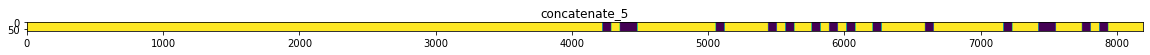

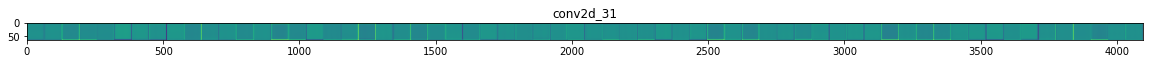

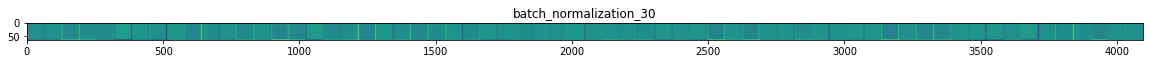

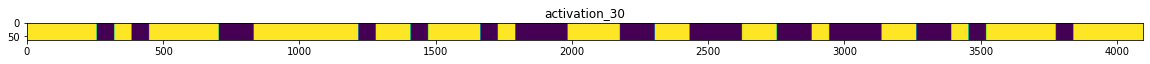

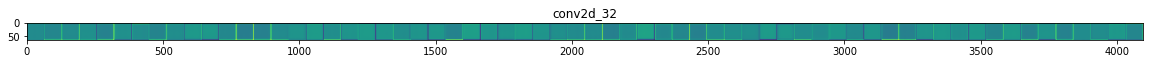

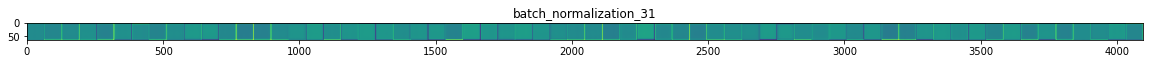

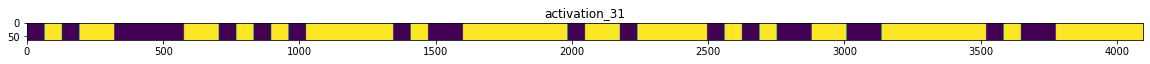

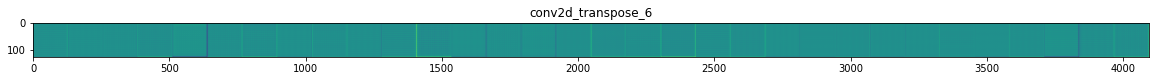

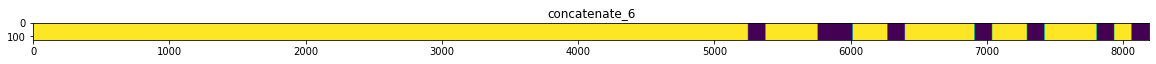

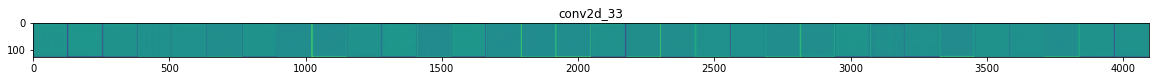

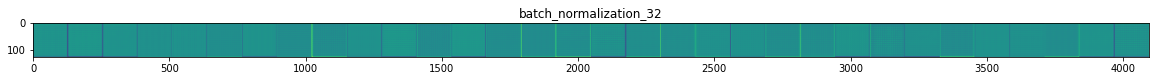

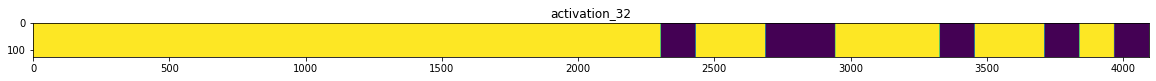

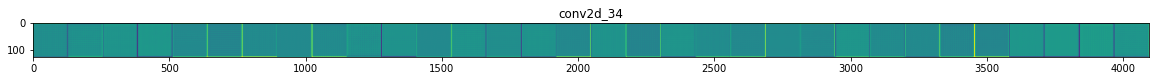

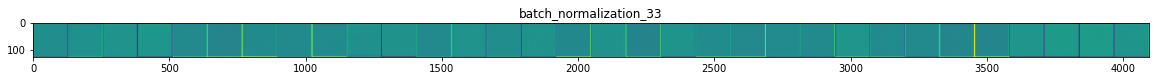

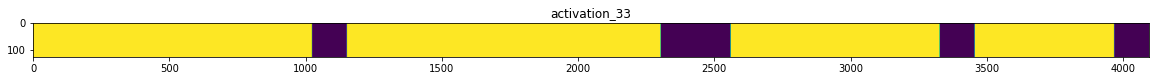

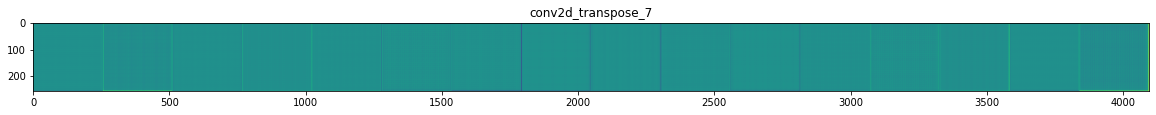

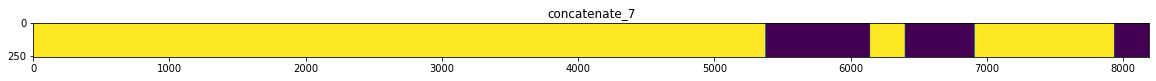

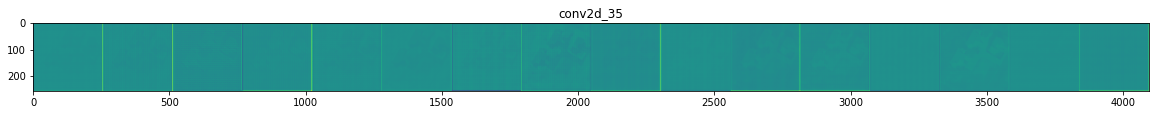

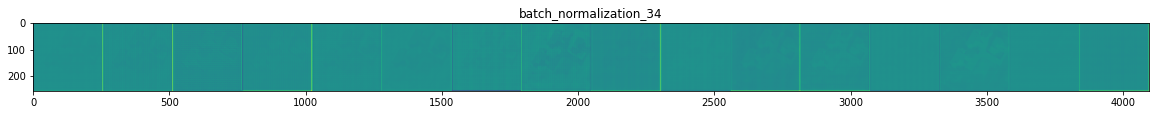

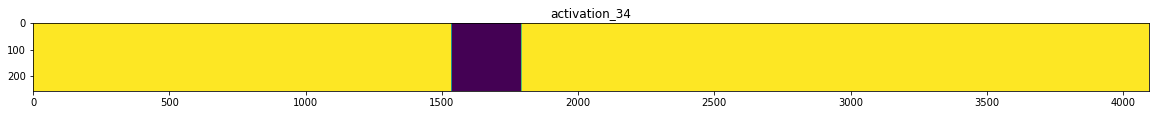

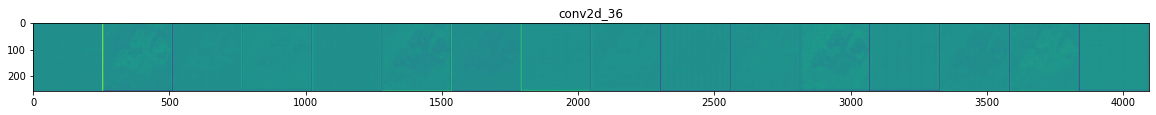

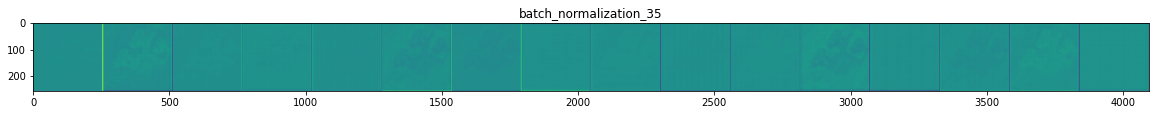

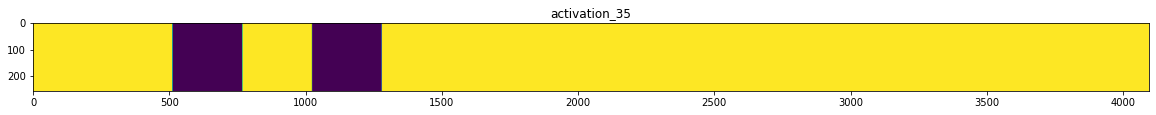

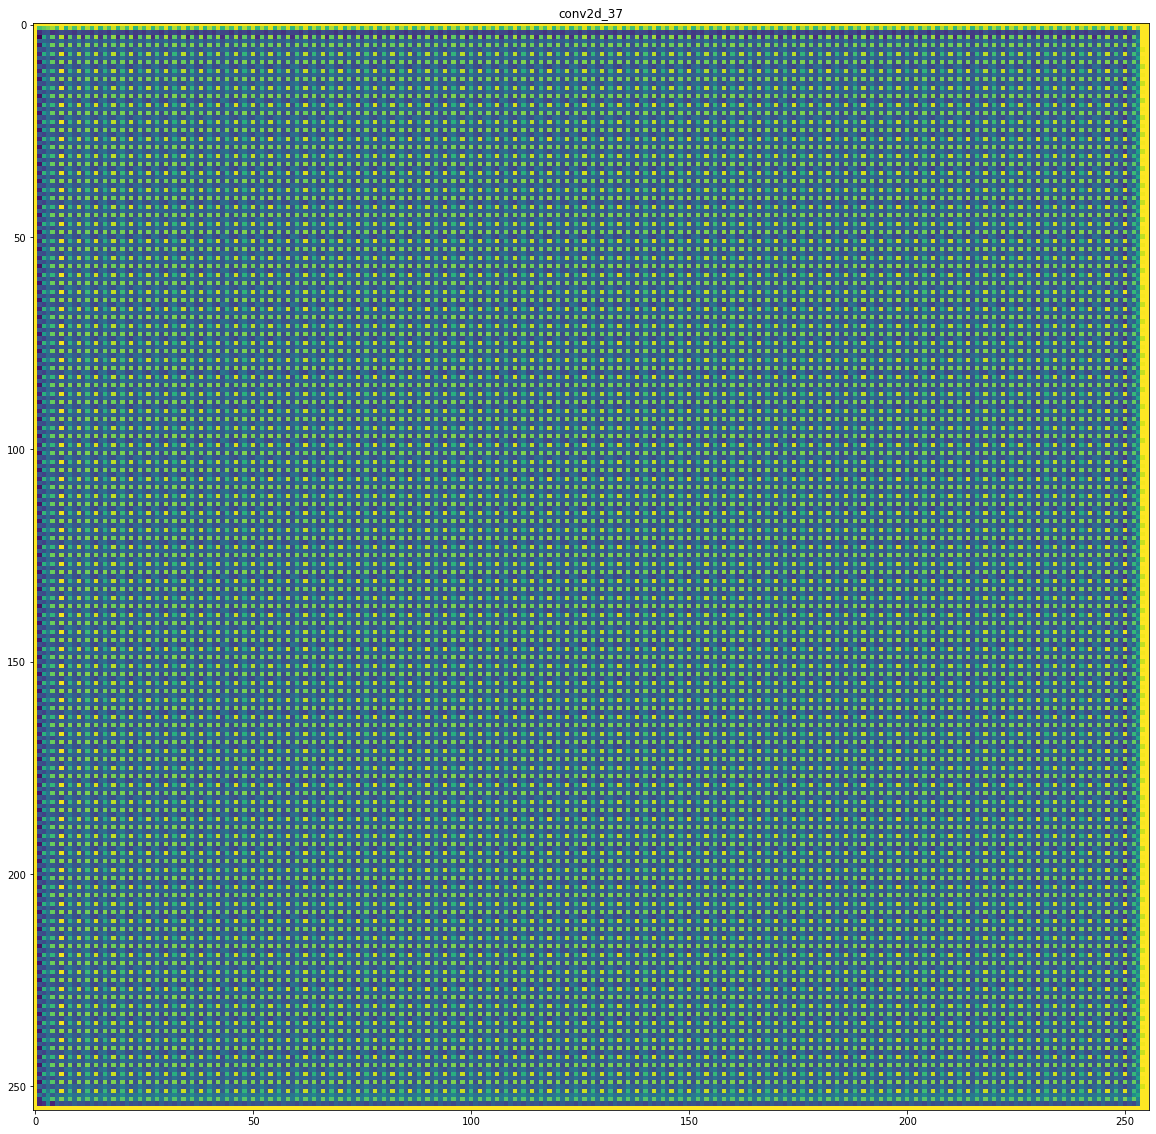

In [48]:
vis_cnn_feature_maps(model,image)

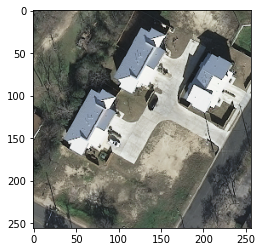

In [42]:
plt.imshow(image)

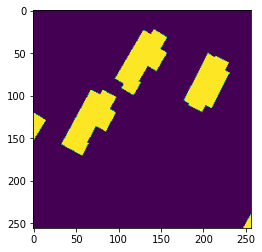

In [38]:
plt.imshow(mask)